# Fetching Dataset

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GlobalMaxPool1D, Conv1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec
import nltk
from nltk.corpus import words, stopwords
from nltk.stem import WordNetLemmatizer
import re


# import data and change columns
df = pd.read_csv('~/Downloads/Twitter_Sentiment_Validation.csv',header=None)
df.columns = ["ID", "entity", "sentiment","content"]

In [20]:
df.head()

,ID,entity,sentiment,content
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         1000 non-null   int64 
 1   entity     1000 non-null   object
 2   sentiment  1000 non-null   object
 3   content    1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


# 1. 워드 임베딩

## (1)	Negative, Positive 레이블 된 데이터만 사용

In [26]:
# exclude neutral and irrelevant sentiment
df = df[(df['sentiment'] != 'Neutral') & (df['sentiment'] != 'Irrelevant')]

label_dict = {'Positive': 1, 'Negative': 0}
y = np.array([label_dict[c] for c in df['sentiment']])

# train-test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['content'].to_list(), y, test_size=0.2, random_state=42)

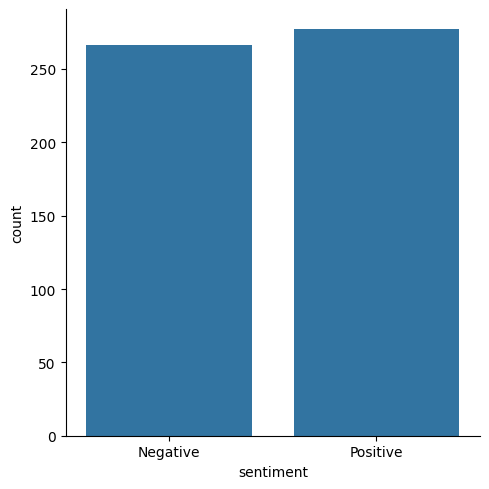

In [28]:
# count plot
sns.catplot(data=df,
           x='sentiment',
           kind = 'count')

## (2)	Word2Vec으로 임베딩

In [31]:
# word2Vec embedding dimension
Embedding_dim = 32

# defining the model input length
input_length = 50 

# convert to list
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

# word2Vec
word2vec_model = Word2Vec(Word2vec_train_data, 
                          vector_size=Embedding_dim, 
                          workers=8, 
                          min_count=5)

# tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['content'].to_list())
vocab_length = len(tokenizer.word_index) + 1

# content to sequences to padding
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), 
                                 maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , 
                                maxlen=input_length)

# embedding matrix
embedding_matrix = np.zeros((vocab_length, Embedding_dim))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

# 2. 분류 모델 적용:

## (1) LSTM을 활용한 감성분석 모델링(학습)

In [35]:
# function of the model
def getModel():
    embedding_layer = Embedding(
        input_dim=vocab_length,
        output_dim=Embedding_dim,
        weights=[embedding_matrix],
        input_length=input_length,
        trainable=True
    )

    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(64, dropout=0.3, return_sequences=True)),
        Conv1D(64, 3, activation='relu'),  # Use kernel_size=3 and 'same' padding
        GlobalMaxPool1D(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ])
    model.build(input_shape=(None, input_length))
    return model

# call the function and compile
training_model = getModel()
training_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
    EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)
]

# train
history = training_model.fit(
    X_train, y_train,
    batch_size=8,
    epochs=15,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/15


/Users/jameslee/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5215 - loss: 0.6913 - val_accuracy: 0.4545 - val_loss: 0.6925 - learning_rate: 0.0010
Epoch 2/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4832 - loss: 0.6956 - val_accuracy: 0.5227 - val_loss: 0.6909 - learning_rate: 0.0010
Epoch 3/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5349 - loss: 0.6866 - val_accuracy: 0.5909 - val_loss: 0.6751 - learning_rate: 0.0010
Epoch 4/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7034 - loss: 0.5999 - val_accuracy: 0.6364 - val_loss: 0.6844 - learning_rate: 0.0010
Epoch 5/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8971 - loss: 0.2970 - val_accuracy: 0.6818 - val_loss: 0.9595 - learning_rate: 0.0010
Epoch 6/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9403 - loss: 0.2155 - val_accuracy: 0.7500 - val_loss: 0.8779 - learning_rate: 0.0010
Epoch 7/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9833 - loss: 0.0602 - val_accuracy: 0.63

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
              precision    recall  f1-score   support

           0       0.89      0.65      0.75        62
           1       0.66      0.89      0.76        47

    accuracy                           0.75       109
   macro avg       0.77      0.77      0.75       109
weighted avg       0.79      0.75      0.75       109



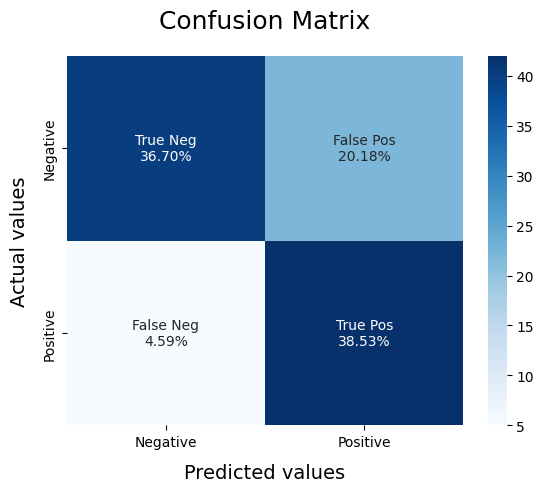

In [36]:
# confusion matrix
def ConfusionMatrix(y_pred, y_test):
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative', 'Positive']
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    sns.heatmap(cf_matrix, annot=labels, cmap='Blues', fmt='',
                xticklabels=categories, yticklabels=categories)
    plt.xlabel("Predicted values", fontdict={'size': 14}, labelpad=10)
    plt.ylabel("Actual values", fontdict={'size': 14}, labelpad=10)
    plt.title("Confusion Matrix", fontdict={'size': 18}, pad=20)

y_pred = training_model.predict(X_test)
y_pred = np.where(y_pred >= 0.5, 1, 0)

ConfusionMatrix(y_pred, y_test)

print(classification_report(y_test, y_pred))

The recall for negative (sentiment) class and precision for positive class  both seems to be significantly low when compared to 0.89. Maybe adjusting some hyperparameters and using preprocessing techniques would help improve overall accuracy

# 3. 성능 평가:

## (1) 2개 이상의 모델 Hyper Parameter 조합에 따른 모델 성능 평가 및 분석


### 1. specify tokenizer + add more layers + change batch and epoch

In [66]:
df = pd.read_csv('~/Downloads/Twitter_Sentiment_Validation.csv',header=None)
df.columns = ["ID", "entity", "sentiment","content"]

df = df[(df['sentiment'] != 'Neutral') & (df['sentiment'] != 'Irrelevant')]

label_dict = {'Positive': 1, 'Negative': 0}
y = np.array([label_dict[c] for c in df['sentiment']])

X_train, X_test, y_train, y_test = train_test_split(df['content'].to_list(), y, test_size=0.2, random_state=42)

Embedding_dim = 32

input_length = 50 

Word2vec_train_data = list(map(lambda x: x.split(), X_train))

word2vec_model = Word2Vec(Word2vec_train_data, 
                          vector_size=Embedding_dim, 
                          workers=8, 
                          min_count=5)

# specify tokenizer
tokenizer = Tokenizer(filters="!\"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(df['content'].to_list())
vocab_length = len(tokenizer.word_index) + 1

X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), 
                                 maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , 
                                maxlen=input_length)

embedding_matrix = np.zeros((vocab_length, Embedding_dim))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

In [68]:
def getModel():
    embedding_layer = Embedding(
        input_dim=vocab_length,
        output_dim=Embedding_dim,
        weights=[embedding_matrix],
        input_length=input_length,
        trainable=True
    )

    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(64, dropout=0.3, return_sequences=True)),
        Conv1D(64, 3, activation='relu'),
        GlobalMaxPool1D(),
        # added more layers
        Dense(16, activation='relu'),
        Dense(16, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ])
    model.build(input_shape=(None, input_length))
    return model

training_model = getModel()
training_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
    EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)
]

history = training_model.fit(
    X_train, y_train,
    # double the batch size and epochs
    batch_size=16,
    epochs=30,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30


/Users/jameslee/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5054 - loss: 0.6973 - val_accuracy: 0.5227 - val_loss: 0.6930 - learning_rate: 0.0010
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5446 - loss: 0.6900 - val_accuracy: 0.5227 - val_loss: 0.6920 - learning_rate: 0.0010
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5260 - loss: 0.6892 - val_accuracy: 0.5227 - val_loss: 0.6905 - learning_rate: 0.0010
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.4962 - loss: 0.6894 - val_accuracy: 0.5227 - val_loss: 0.6875 - learning_rate: 0.0010
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5210 - loss: 0.6650 - val_accuracy: 0.6591 - val_loss: 0.6903 - learning_rate: 0.0010
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6932 - loss: 0.6015 - val_accuracy: 0.7045 - val_loss: 0.6113 - learning_rate: 0.0010
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9010 - loss: 0.3753 - val_accuracy: 0.59

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
              precision    recall  f1-score   support

           0       0.90      0.69      0.78        62
           1       0.69      0.89      0.78        47

    accuracy                           0.78       109
   macro avg       0.79      0.79      0.78       109
weighted avg       0.81      0.78      0.78       109



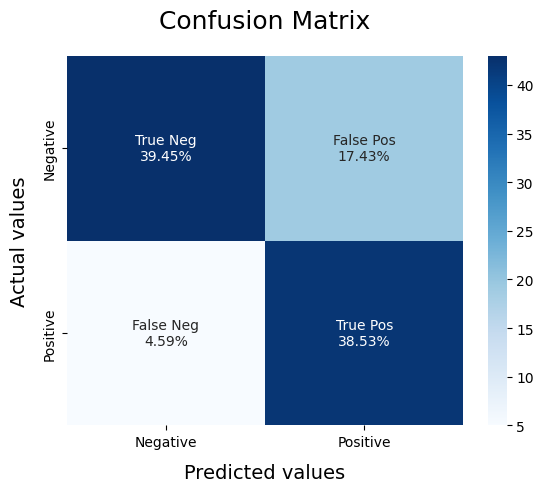

In [69]:
def ConfusionMatrix(y_pred, y_test):
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative', 'Positive']
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    sns.heatmap(cf_matrix, annot=labels, cmap='Blues', fmt='',
                xticklabels=categories, yticklabels=categories)
    plt.xlabel("Predicted values", fontdict={'size': 14}, labelpad=10)
    plt.ylabel("Actual values", fontdict={'size': 14}, labelpad=10)
    plt.title("Confusion Matrix", fontdict={'size': 18}, pad=20)

y_pred = training_model.predict(X_test)
y_pred = np.where(y_pred >= 0.5, 1, 0)

ConfusionMatrix(y_pred, y_test)

print(classification_report(y_test, y_pred))

When compared to the previous performance, the precision and recall for both class increased at 0.78 but not a significant amount. Therefore, it seems specifying the tokenizer and making some changes in layers, batch, epoch didn't affect much. In the next model, it would be more focused towards preprocessing.

### 2. only include words in english words + no stopwords + lemmatize

In [159]:
df = pd.read_csv('~/Downloads/Twitter_Sentiment_Validation.csv',header=None)
df.columns = ["ID", "entity", "sentiment","content"]
df = df[(df['sentiment'] != 'Neutral') & (df['sentiment'] != 'Irrelevant')]

english_words = set(words.words())  # english words
stop_words = set(stopwords.words('english')) # stopwords
lemmatizer = WordNetLemmatizer() # lemmatize

# cleaning text function
def clean_text_and_filter(text):
    # remove special characters
    text = re.sub(r'[^a-zA-Z\s]', "", text)  
    
    # lowercase and strip whitespace
    text = text.lower().strip()
    
    # englishwords, no stopwords, and lemmatize
    filter = [
        lemmatizer.lemmatize(word) 
        for word in text.split() 
        if word in english_words and word not in stop_words
    ]
    
    return " ".join(filter)
    
df['content'] = df['content'].apply(clean_text_and_filter)

label_dict = {'Positive': 1, 'Negative': 0}
y = np.array([label_dict[c] for c in df['sentiment']])

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['content'].to_list(), y, test_size=0.2, random_state=42)

Embedding_dim = 32

input_length = 50 

Word2vec_train_data = list(map(lambda x: x.split(), X_train))

word2vec_model = Word2Vec(Word2vec_train_data, 
                          vector_size=Embedding_dim, 
                          workers=8, 
                          min_count=5)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['content'].to_list())
vocab_length = len(tokenizer.word_index) + 1

X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), 
                                 maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , 
                                maxlen=input_length)

embedding_matrix = np.zeros((vocab_length, Embedding_dim))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

In [161]:
def getModel():
    embedding_layer = Embedding(
        input_dim=vocab_length,
        output_dim=Embedding_dim,
        weights=[embedding_matrix],
        input_length=input_length,
        trainable=True
    )

    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(64, dropout=0.3, return_sequences=True)),
        Conv1D(64, 3, activation='relu'),  # Use kernel_size=3 and 'same' padding
        GlobalMaxPool1D(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ])
    model.build(input_shape=(None, input_length))
    return model

training_model = getModel()
training_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
    EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)
]

history = training_model.fit(
    X_train, y_train,
    batch_size=8,
    epochs=15,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/15


/Users/jameslee/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5337 - loss: 0.6909 - val_accuracy: 0.5682 - val_loss: 0.6926 - learning_rate: 0.0010
Epoch 2/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6046 - loss: 0.6813 - val_accuracy: 0.5909 - val_loss: 0.6644 - learning_rate: 0.0010
Epoch 3/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8459 - loss: 0.5162 - val_accuracy: 0.6136 - val_loss: 0.6617 - learning_rate: 0.0010
Epoch 4/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9278 - loss: 0.2105 - val_accuracy: 0.6818 - val_loss: 0.7880 - learning_rate: 0.0010
Epoch 5/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9658 - loss: 0.1029 - val_accuracy: 0.6364 - val_loss: 1.0210 - learning_rate: 0.0010
Epoch 6/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9780 - loss: 0.0618 - val_accuracy: 0.6818 - val_loss: 1.3462 - learning_rate: 0.0010
Epoch 7/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9937 - loss: 0.0262 - val_accuracy: 0.65

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
              precision    recall  f1-score   support

           0       0.78      0.74      0.76        62
           1       0.68      0.72      0.70        47

    accuracy                           0.73       109
   macro avg       0.73      0.73      0.73       109
weighted avg       0.74      0.73      0.73       109



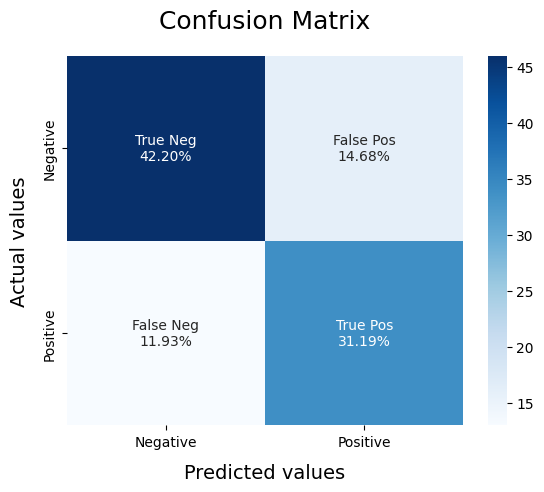

In [162]:
def ConfusionMatrix(y_pred, y_test):
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative', 'Positive']
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    sns.heatmap(cf_matrix, annot=labels, cmap='Blues', fmt='',
                xticklabels=categories, yticklabels=categories)
    plt.xlabel("Predicted values", fontdict={'size': 14}, labelpad=10)
    plt.ylabel("Actual values", fontdict={'size': 14}, labelpad=10)
    plt.title("Confusion Matrix", fontdict={'size': 18}, pad=20)

y_pred = training_model.predict(X_test)
y_pred = np.where(y_pred >= 0.5, 1, 0)

ConfusionMatrix(y_pred, y_test)

print(classification_report(y_test, y_pred))

It seems there hasn't been much of a change despite utilizing preprocessing techniques like removing stopwords, lemmantizing, and only including words in english_words. Perhaps using glove instead of word2vec would help.

### 3. Glove instead of word2vec

In [168]:
df = pd.read_csv('~/Downloads/Twitter_Sentiment_Validation.csv',header=None)
df.columns = ["ID", "entity", "sentiment","content"]
df = df[(df['sentiment'] != 'Neutral') & (df['sentiment'] != 'Irrelevant')]

english_words = set(words.words())  # english words
stop_words = set(stopwords.words('english')) # stopwords
lemmatizer = WordNetLemmatizer() # lemmatize

# cleaning text function
def clean_text_and_filter(text):
    # remove special characters
    text = re.sub(r'[^a-zA-Z\s]', "", text)  
    # lowercase and strip whitespace
    text = text.lower().strip()
    # englishwords, no stopwords, and lemmatize
    filter = [
        lemmatizer.lemmatize(word) 
        for word in text.split() 
        if word in english_words and word not in stop_words
    ]
    return " ".join(filter)
    
df['content'] = df['content'].apply(clean_text_and_filter)

label_dict = {'Positive': 1, 'Negative': 0}
y = np.array([label_dict[c] for c in df['sentiment']])

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['content'].to_list(), y, test_size=0.2, random_state=42)

embedding_dim = 200
input_length = 50

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['content'].to_list())
vocab_length = len(tokenizer.word_index) + 1

X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=input_length)

# glove embeddings
glove_file_path = "downloads/glove.6B.200d.txt"
embeddings_index = {}

# dictionary that maps each word to its matching vector. Written by CHATgpt 
with open(glove_file_path, 'r', encoding='utf-8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vectors

embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, token in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[token] = embedding_vector

In [169]:
def getModel():
    embedding_layer = Embedding(
        input_dim=vocab_length,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=input_length,
        trainable=True
    )

    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(64, dropout=0.3, return_sequences=True)),
        Conv1D(64, 3, activation='relu'),  # Use kernel_size=3 and 'same' padding
        GlobalMaxPool1D(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ])
    model.build(input_shape=(None, input_length))
    return model

training_model = getModel()
training_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
    EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)
]

history = training_model.fit(
    X_train, y_train,
    batch_size=8,
    epochs=15,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/15


/Users/jameslee/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5141 - loss: 0.6920 - val_accuracy: 0.5909 - val_loss: 0.6747 - learning_rate: 0.0010
Epoch 2/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7519 - loss: 0.5430 - val_accuracy: 0.5909 - val_loss: 0.7954 - learning_rate: 0.0010
Epoch 3/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8669 - loss: 0.3418 - val_accuracy: 0.6136 - val_loss: 0.9264 - learning_rate: 0.0010
Epoch 4/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8863 - loss: 0.2599 - val_accuracy: 0.5682 - val_loss: 1.2034 - learning_rate: 0.0010
Epoch 5/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9284 - loss: 0.1785 - val_accuracy: 0.6364 - val_loss: 1.0478 - learning_rate: 0.0010
Epoch 6/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9434 - loss: 0.1212 - val_accuracy: 0.6136 - val_loss: 1.5054 - learning_rate: 0.0010
Epoch 7/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9726 - loss: 0.0585 - val_accuracy: 0.68

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
              precision    recall  f1-score   support

           0       0.84      0.76      0.80        62
           1       0.72      0.81      0.76        47

    accuracy                           0.78       109
   macro avg       0.78      0.78      0.78       109
weighted avg       0.79      0.78      0.78       109



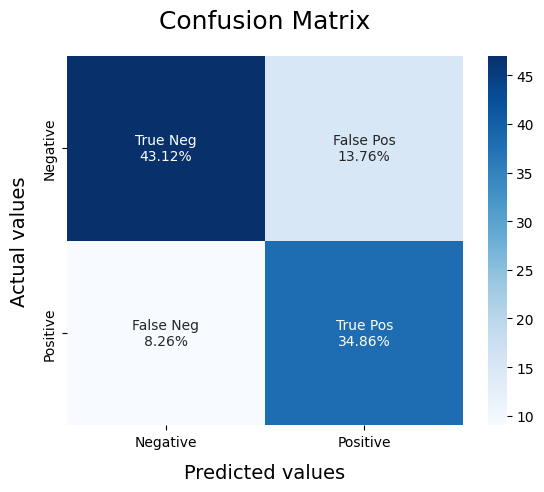

In [170]:
def ConfusionMatrix(y_pred, y_test):
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative', 'Positive']
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    sns.heatmap(cf_matrix, annot=labels, cmap='Blues', fmt='',
                xticklabels=categories, yticklabels=categories)
    plt.xlabel("Predicted values", fontdict={'size': 14}, labelpad=10)
    plt.ylabel("Actual values", fontdict={'size': 14}, labelpad=10)
    plt.title("Confusion Matrix", fontdict={'size': 18}, pad=20)

y_pred = training_model.predict(X_test)
y_pred = np.where(y_pred >= 0.5, 1, 0)

ConfusionMatrix(y_pred, y_test)

print(classification_report(y_test, y_pred))

Choosing GloVe instead of Word2Vec definitely helped increase the F1-scores for both class 0 and class 1, achieving 0.8 and 0.76, respectively. This improvement is likely due to GloVe's ability to capture global word-to-word co-occurrence statistics of words, which provided more meaningful word embeddings for predicting the sentiment of the content.